<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 9 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 4 November 2019, with material from Jake Vanderplas</div>

# Gaussian Mixture Models

[Gaussian Mixture Models](https://scikit-learn.org/stable/modules/mixture.html) (GMM) are a neat methodolgy for modelling observations that stem from *multiple groupings*. 

A [mixture model](https://en.wikipedia.org/wiki/Mixture_model) is a probabilistic model for representing the presence of subpopulations within an overall population, without requiring that an observed data set should identify the sub-population to which an individual observation belongs. 

Mixture models are used to make statistical inferences about the properties of sub-populations given only observations on the pooled population, without sub-population identity information.

Let's draw normal distributions from 3 different populations and mix them in.

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


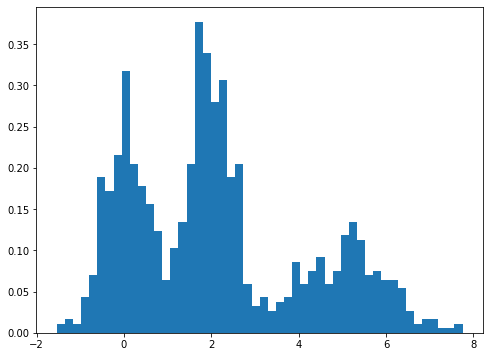

In [56]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

SEED = 25
np.random.seed(SEED) 

N = 1000
W = np.array([0.35, 0.4, 0.25])
MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

component = np.random.choice(MU.size, size=N, p=W)  #1st arg: arange(MU.size), p: probabilities associated with each 1sy arg entry 
x = np.random.normal(MU[component], SIGMA[component], size=N) #random samples from a normal distribution @ 1st arg

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=50, normed=True, lw=0);

Specify and fit a marginalized Gaussian mixture model (GMM) to this data in `PyMC3`. Here, we introduce a new pdf called **Dirichlet**. The [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) is the multivariate generalization of the beta distribution (our "baseball" distribution, used to model the behavior of random variables limited to intervals of finite length). It is used a lot in [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP).

The Dirichlet pdf does not sample from the space of real numbers, like the normal pdf does. Instead it samples over a probability simplex (probabilities over $n$ distinct categories, representing the dimensions of our multivariate distribution). A 4-dimentional Dirichlet distribution has 4 parameters. So, it's tailor-made for mixture models.

In [58]:
with pm.Model() as model_mm:
    w = pm.Dirichlet('w', np.ones_like(W))  #array of ones with the same shape and type as W

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [59]:
with model_mm:
    trace_mm = pm.sample(5000, n_init=10000, tune=1000, random_seed=SEED)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:53<00:00, 448.08draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


The posterior distribution on the weights and the component means has captured the true value quite well:

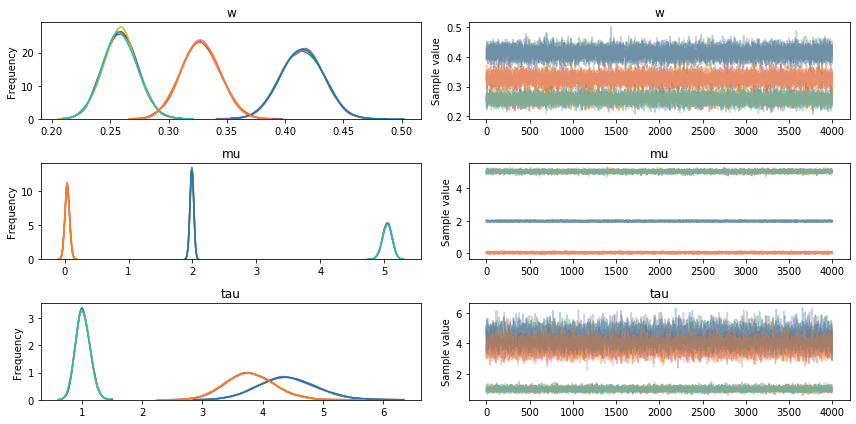

In [60]:
pm.traceplot(trace_mm, varnames=['w', 'mu', 'tau']);

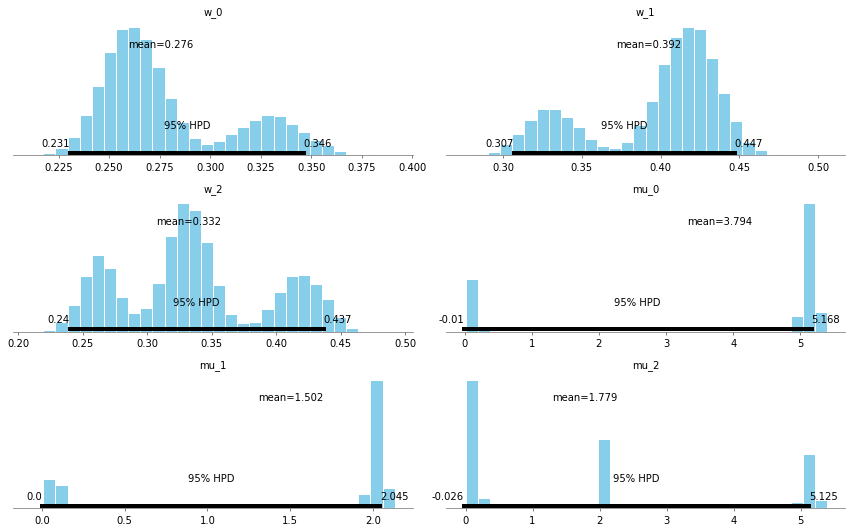

In [61]:
pm.plot_posterior(trace_mm, varnames=['w', 'mu']);

Let's sample from the model’s posterior predictive distribution:

In [62]:
with model_mm:
    ppc_trace = pm.sample_ppc(trace_mm, 5000, random_seed=SEED)

100%|██████████| 5000/5000 [00:10<00:00, 483.20it/s]


and let's plot:

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


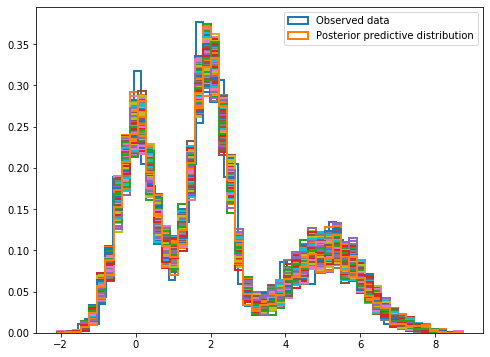

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=50, normed=True,
        histtype='step', lw=2,
        label='Observed data');

ax.hist(ppc_trace['x_obs'], bins=50, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);

Not too shabby...

If a sports team is comprised of 11 players, each with his own abilities in passes or distance covered (with a superstar on some teams with way above average abilities, e.g. a Christiano Ronaldo, or a Lionel Messi), then team abilities could be modeled as a GMM. That way, you could go from individual player rankings to complete team rankings.

## Cheating

We are cheating her era little bit, aren't we? We **specify** the number of gaussians in the mixture! It's a bit as if we doing KMeans where we specify the number of **clusters** in the model.

Can we do better? Assume we have another similar one-dimensional distribution:

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':


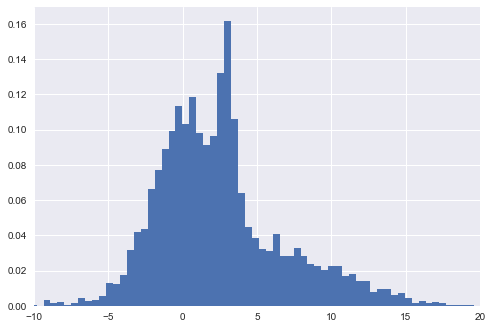

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

`Scikit-learn`'s Gaussian Mixture Models (GMM) will allow us to approximate this density:

d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_de

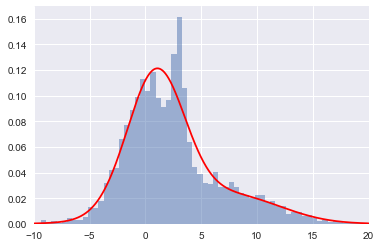

In [2]:
from sklearn.mixture import GMM
X = x[:, np.newaxis]
clf = GMM(4, n_iter=500, random_state=3).fit(X)
xpdf = np.linspace(-10, 20, 1000)
density = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [3]:
clf.means_

array([[0.25306823],
       [3.96038601],
       [1.45350312],
       [9.56303626]])

In [4]:
clf.covars_

array([[ 6.4601766 ],
       [23.19014431],
       [ 5.80884786],
       [14.79998213]])

In [5]:
clf.weights_

array([0.31823886, 0.21876416, 0.35341345, 0.10958354])

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


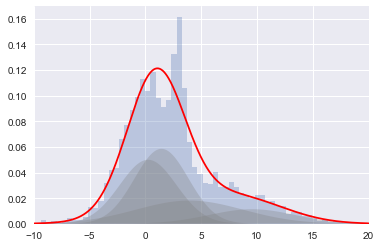

In [6]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikake Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

In [7]:
print(clf.bic(X))
print(clf.aic(X))

25911.193780408266
25840.42185300102


d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


Let's take a look at these as a function of the number of gaussians:

In [ ]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, n_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, 4 components is preferred!

## Use Case: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.

One thing that generative models can be useful for is **outlier detection**: We can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where **suitable** is up to your own bias/variance preference) can be labeled outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [8]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_de

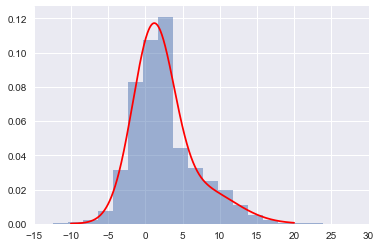

In [9]:
clf = GMM(4, n_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(y, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


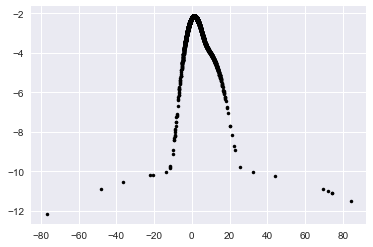

In [10]:
log_likelihood = clf.score_samples(y[:, np.newaxis])[0]
plt.plot(y, log_likelihood, '.k');

In [11]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2135 2163 2222 2496 2732 2893 2897 3067 3173
 3253 3468 3483 4373]


The algorithm **misses** a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed (false negatives):

In [12]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers (false positives):

In [13]:
set(detected_outliers) - set(true_outliers)

{3067, 3173, 3253, 3483}

Although all of the above is done in one dimension, GMM does generalize to multiple dimensions!

### Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

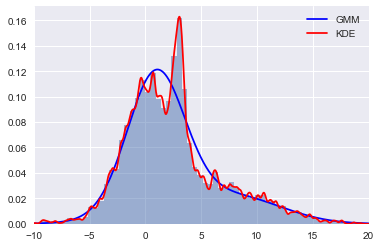

In [14]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.